In [1]:
from langchain_ollama import ChatOllama
model = ChatOllama(model="gemma3:1b", temperature=0)

In [2]:
model.invoke("hey")

AIMessage(content='Hey there! How’s your day going so far? 😊 \n\nIs there anything you’d like to chat about or any help I can offer?', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:23:42.7421123Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2513654100, 'load_duration': 315747100, 'prompt_eval_count': 10, 'prompt_eval_duration': 1214483500, 'eval_count': 33, 'eval_duration': 975122100, 'model_name': 'gemma3:1b'}, id='run--ab2d6efa-cc2b-48e7-8785-5385a6353839-0', usage_metadata={'input_tokens': 10, 'output_tokens': 33, 'total_tokens': 43})

In [3]:
def llm(state):
    print("LLM Node")
    return {"messages": model.invoke(state["messages"])}

def cache(state):
    print('waste')
    return {"messages": state["messages"]}

In [10]:
from langgraph.graph import StateGraph, START, END, MessagesState

builder = StateGraph(MessagesState)
builder.add_node("llm", llm)
builder.add_node("cache", cache)
builder.add_edge(START, 'llm')
builder.add_edge('llm', 'cache')
builder.add_edge('cache', END)

graph = builder.compile()

In [58]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
graph.invoke({'messages': HumanMessage(content='hey')})

LLM Node
waste


{'messages': [HumanMessage(content='hey', additional_kwargs={}, response_metadata={}, id='0f2ae083-b0e3-4938-a5ff-99d43b2aac0b'),
  AIMessage(content='Hey there! How’s your day going so far? 😊 \n\nIs there anything you’d like to chat about or any help I can offer?', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:48:50.1662433Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1722399500, 'load_duration': 131575800, 'prompt_eval_count': 10, 'prompt_eval_duration': 642480400, 'eval_count': 33, 'eval_duration': 947919900, 'model_name': 'gemma3:1b'}, id='run--c938c39f-8cd2-484a-8f8d-e32c9d7f8b8c-0', usage_metadata={'input_tokens': 10, 'output_tokens': 33, 'total_tokens': 43})]}

In [ ]:
# No, memory Will Use checkpointer lol who tf cares
# Now time for designing

In [9]:
# Now On for the better part...
# Lets just make the langgraph flow without worrying about llm hallucinations for now. 
# I am not building it just for gemma3:1b. We also have bigger non reasoning models like qw3n 1.5 gemma3 4b and 7b...

In [ ]:
class ExtendedState(MessagesState):
    parsed_problem: str
    plans: str
    sims: str
    recommend: str
    recommended_plan: str
    refined_plan: str

# Pretty rudimentary State for now, it ll work though
    

In [13]:
def parse_problem(state):
    prompt = f"""
You are a problem parser.  
Your task is to deeply understand the user's request and extract:  
1. **Two Core objectives** : the main things they want.  
2. **Constraints** : any limits, rules, or conditions.  
3. **Key entities** : important objects, people, variables, or data.  
4. **Success criteria** : what a good answer must achieve.  

Do not solve the problem. Only rewrite and structure it for later reasoning.  
Return the output as structured JSON.
Problem:
    {state['messages']}
"""
    sys_msg = SystemMessage(content=prompt)
    return {'parsed_problem': model.invoke(prompt)}

In [14]:
def generate_plans(state):
    prompt = f"""
You are a strategic planner.  
Given the parsed problem (core objective, constraints, key entities, success criteria),  
generate multiple possible solution approaches.  

Rules:  
- Propose at least 3 distinct plans.  
- Each plan should list the main steps, assumptions, and potential risks.  
- Plans should stay within the provided constraints.  
- Do not execute the solution. Only outline strategies. 

Return the output as structured JSON.
Problem:
{state['parsed_problem']}
"""
    
    return {'plans': model.invoke(prompt)}

In [ ]:
builder2 = StateGraph(ExtendedState)
builder2.add_node('parse_problem', parse_problem)
builder2.add_node('generate_plans', generate_plans)

builder2.add_edge(START, "parse_problem")
builder2.add_edge("parse_problem", "generate_plans")
builder2.add_edge("generate_plans", END)

graph2 = builder2.compile()

In [ ]:
graph2.invoke({'messages': HumanMessage(content = "Write a small report about artificial intelligence in military")})

In [57]:
PARSED_PROBLEM = "Okay, here's a structured breakdown of the problem, focusing on extracting the core objective, constraints, key entities, and success criteria:\n\n**1. Core Objective:**\n\nThe user wants a report detailing the integration and impact of artificial intelligence (AI) within military applications.  Specifically, the report should explore how AI is being utilized, its potential benefits and risks, and any associated strategic considerations.\n\n**2. Constraints:**\n\n*   **Length:** The report should be concise – approximately 500-700 words.\n*   **Target Audience:**  The report is intended for a non-technical audience with a general understanding of military operations.\n*   **Format:** The report should be structured logically, likely including an introduction, key areas of AI application, potential benefits, risks, and concluding remarks.\n*   **Focus:** The report should primarily concentrate on *current* and *potential* applications of AI in military contexts, rather than a comprehensive historical overview.\n\n**3. Key Entities:**\n\n*   **Artificial Intelligence (AI):** The central technology being discussed.\n*   **Military:** The domain of application – encompassing defense, intelligence, logistics, and operations.\n*   **Specific AI Applications:** (To be identified – examples include: autonomous weapons systems, predictive analytics for threat assessment, AI-powered logistics optimization, surveillance and reconnaissance, cybersecurity, training simulations, etc.)\n*   **Strategic Implications:** The broader effects of AI integration on military strategy, tactics, and operations.\n*   **Potential Risks:**  Cybersecurity vulnerabilities, algorithmic bias, unintended consequences, ethical concerns, and the potential for escalation.\n\n**4. Success Criteria:**\n\n*   **Clarity & Accuracy:** The report should present a clear and accurate understanding of AI's role in military applications, avoiding overly technical jargon.\n*   **Comprehensive Overview:** The report should cover a reasonable range of key areas, demonstrating a basic understanding of the topic.\n*   **Logical Structure:** The report should be well-organized and easy to follow, with a clear introduction, body, and conclusion.\n*   **Conciseness:** The report should be within the specified word count limit.\n*   **Relevance:** The report should demonstrate a focus on *current* and *potential* applications, rather than a broad historical analysis.\n\n---\n\nLet me know if you'd like me to elaborate on any of these aspects or generate further questions to refine the problem!"
# print(f"{PARSED_PROBLEM}")
PLANS = """ ```json\n{\n  "solution_approaches": [\n    {\n      "approach_name": "Focused Case Study Analysis",\n      "description": "Identify and analyze 2-3 specific military applications of AI currently in use.  Focus on concrete examples rather than broad overviews.",\n      "steps": [\n        "Select 2-3 distinct military applications (e.g., autonomous drone control, predictive maintenance of military vehicles, AI-powered battlefield analytics).",\n        "Gather data on each application – including the AI technology used, the operational context, and the results achieved.",\n        "Create concise summaries for each application, highlighting key benefits and challenges.",\n        "Structure the report around these summaries, providing a clear narrative of how AI is being applied."\n      ],\n      "assumptions": [\n        "Access to reliable data sources for each application.",\n        "Understanding of basic military operational concepts."\n      ],\n      "potential_risks": [\n        "Data availability limitations – specific applications may have limited publicly available data.",\n        "Difficulty in accurately quantifying the benefits and challenges of each application.",\n        "Bias in data – data may reflect existing biases within the military or AI development."\n      ]\n    },\n    {\n      "approach_name": "Trend Analysis & Future Outlook",\n      "description": "Explore current trends in AI and military applications to predict future developments.  Focus on potential shifts in strategy.",\n      "steps": [\n        "Research current trends in AI research and development (e.g., deep learning, reinforcement learning, natural language processing).",\n        "Identify emerging military applications leveraging AI (e.g., AI-driven logistics, cyber warfare, intelligence gathering).",\n        "Analyze potential future shifts in military strategy that could be influenced by AI.",\n        "Synthesize this information into a brief overview of potential future trends."\n      ],\n      "assumptions": [\n        "Significant advancements in AI technology will continue.",\n        "Military organizations will increasingly adopt AI-driven solutions.",\n        "Strategic considerations will evolve to incorporate AI."\n      ],\n      "potential_risks": [\n        "Overly optimistic predictions – AI may not always deliver on its promises.",\n        "Unforeseen technological disruptions – new technologies could render existing AI applications obsolete.",\n        "Ethical concerns – the use of AI in military contexts raises ethical questions."\n      ]\n    },\n    {\n      "approach_name": "Comparative Analysis - Existing vs. Emerging",\n      "description": "Compare and contrast current AI applications with those that are still under development.  Highlight the differences in scope and potential impact.",\n      "steps": [\n        "Identify 2-3 examples of AI currently being used in military contexts (e.g., facial recognition, predictive maintenance, autonomous navigation).",\n        "Analyze the capabilities and limitations of each example.",\n        "Compare and contrast these examples with emerging AI technologies (e.g., generative AI, edge AI).",\n        "Summarize the key differences and potential implications of each approach."\n      ],\n      "assumptions": [\n        "Existing military systems are relatively stable and well-understood.",\n        "Emerging AI technologies are likely to be more adaptable and flexible."\n      ],\n      "potential_risks": [\n        "Rapid technological change – existing AI applications may become obsolete quickly.",\n        "Difficulty in predicting the long-term impact of emerging AI technologies.",\n        "Potential for unintended consequences – AI systems may behave in unexpected ways."\n      ]\n    }\n  ]\n}\n```"
"""
print(f"PLANS - \n {PLANS}")

PLANS - 
  ```json
{
  "solution_approaches": [
    {
      "approach_name": "Focused Case Study Analysis",
      "description": "Identify and analyze 2-3 specific military applications of AI currently in use.  Focus on concrete examples rather than broad overviews.",
      "steps": [
        "Select 2-3 distinct military applications (e.g., autonomous drone control, predictive maintenance of military vehicles, AI-powered battlefield analytics).",
        "Gather data on each application – including the AI technology used, the operational context, and the results achieved.",
        "Create concise summaries for each application, highlighting key benefits and challenges.",
        "Structure the report around these summaries, providing a clear narrative of how AI is being applied."
      ],
      "assumptions": [
        "Access to reliable data sources for each application.",
        "Understanding of basic military operational concepts."
      ],
      "potential_risks": [
        "D

In [59]:
graph2.invoke({'messages': HumanMessage(content = "What can be the potential exits to our universe?")})

{'messages': [HumanMessage(content='What can be the potential exits to our universe?', additional_kwargs={}, response_metadata={}, id='7df39a7c-2cee-4841-825a-d979c5421b2d')],
 'parsed_problem': AIMessage(content='```json\n{\n  "core_objectives": [\n    "Understanding the potential exit points of the universe.",\n    "Exploring different possibilities and pathways within the universe."\n  ],\n  "constraints": [\n    "The focus is on potential exits, not necessarily definitive answers.",\n    "The response should be exploratory and open-ended.",\n    "The response should be understandable to a general audience."\n  ],\n  "key_entities": [\n    "Universe",\n    "Exits",\n    "Potential pathways"\n  ],\n  "success_criteria": [\n    "Provide a range of possible scenarios or explanations for potential exits.",\n    "Demonstrate an understanding of the concept of \'exits\' in a cosmological context.",\n    "Offer a variety of potential explanations without requiring a specific answer."\n  ]\

In [60]:
exits1 = """
    ```json\n{\n  "core_objective": "Explore potential pathways or solutions to achieve a desired outcome, potentially relating to a hypothetical scenario.",\n  "constraints": [\n    "Focus on the realm of science and potential theoretical possibilities.",\n    "The goal is to identify possible \'exits\' or resolutions, not necessarily practical implementations.",\n    "The response should be exploratory and conceptual, not prescriptive."\n  ],\n  "key_entities": [\n    "Reality",\n    "Science",\n    "Exits/Solutions"\n  ],\n  "success_criteria": "The response should demonstrate an understanding of the concept of \'exits\' within a scientific context, even if it doesn\'t provide a concrete answer to the original question. It should articulate a range of potential avenues or possibilities."\n}\n```\n
 """
print(f"EXITS - \n {exits1}")


EXITS - 
 
    ```json
{
  "core_objective": "Explore potential pathways or solutions to achieve a desired outcome, potentially relating to a hypothetical scenario.",
  "constraints": [
    "Focus on the realm of science and potential theoretical possibilities.",
    "The goal is to identify possible 'exits' or resolutions, not necessarily practical implementations.",
    "The response should be exploratory and conceptual, not prescriptive."
  ],
  "key_entities": [
    "Reality",
    "Science",
    "Exits/Solutions"
  ],
  "success_criteria": "The response should demonstrate an understanding of the concept of 'exits' within a scientific context, even if it doesn't provide a concrete answer to the original question. It should articulate a range of potential avenues or possibilities."
}
```

 


In [49]:
def simulator(state):
    prompt1 = """You are a logical reasoner.  
Given the problems and multiple solution plans, your job is to simulate each plan step-by-step,  
check its feasibility, and evaluate it against the problem's constraints and success criteria.  

Rules:
- For each plan, simulate the steps in order.  
- After each step, note expected outcomes and possible issues.  
- Identify where the plan may fail or need adjustments.  
- Do not give the final answer yet — only reasoning traces and evaluations.  

Return output as JSON.
Simulate reasoning in this format:
"plan_evaluations": [
    {
      "plan_name": "Approach 1",
      "reasoning_chain": [
        {"step": "...", "expected_outcome": "...", "possible_issues": ["..."]},
        {"step": "...", "expected_outcome": "...", "possible_issues": ["..."]}
      ],
      "overall_feasibility": "High | Medium | Low",
      "notes": "..."
    },
    {
      "plan_name": "Approach 2",
      "reasoning_chain": [...],
      "overall_feasibility": "...",
      "notes": "..."
    }
  ]
}
"""
    prompt2 = f"""
  Parsed Problems:
  {state['parsed_problem']}
  Solution Plans:
  {state['plans']}
"""
    return {'sims': model.invoke(prompt1 + prompt2)}

In [50]:
def critique(state):
    prompt1 = f"""You are a self-critique and evaluation module.  
    Given simulated reasoning chains for multiple plans,  
    your task is to critically review them, identify flaws, and select the most promising approach.  

    Rules:  
    - Compare feasibility, risk, and alignment with success criteria.  
    - Point out specific weaknesses or logical gaps in each plan.  
    - Recommend one plan as the best candidate, with justification.  
    - Do not solve the problem — only select and justify the choice.  

    Return output as JSON.
    PARSED PROBLEM:
    {state['parsed_problem']}

    PLAN EVALUATIONS:
    {state['plans']}

    SIMULATIONS:
    {state['sims']}"""

    prompt2 = """Evaluate and select in this format:
    {
    "plan_reviews": [
        {
        "plan_name": "Approach 1",
        "strengths": ["...", "..."],
        "weaknesses": ["...", "..."],
        "risk_level": "High | Medium | Low",
        "alignment_with_criteria": "Strong | Moderate | Weak"
        },
        {
        "plan_name": "Approach 2",
        "strengths": [...],
        "weaknesses": [...],
        "risk_level": "...",
        "alignment_with_criteria": "..."
        }
    ],
    "recommended_plan": {
        "name": "...",
        "justification": "..."
    }
    }
    """
    
    return {'recommend': model.invoke(prompt1 + prompt2)}

In [51]:
def recommended_plan(state):
    
    """
    string2 =    "recommended_plan": {
    #       "name": "...",
    #        "justification": "..."
      #  }
     #   
    string2.split("recommended_plan")[1:]"""


    recommend_plan_str = state['recommend'].content
    return {"recommended_plan": recommend_plan_str.split('recommended_plan')[1:]}

In [52]:
def refiner(state):
  prompt1 = f"""
      You are a plan refiner.  
      Given the recommended plan and its identified weaknesses,  
      your job is to improve it while keeping the core objective and constraints intact.  

      Rules:  
      - Address each weakness directly with concrete changes.  
      - Reduce risk and improve feasibility.  
      - Keep all steps logically connected.  
      - If the plan is fundamentally flawed, propose a revised version from scratch that is stronger.  
      - Do not produce the final answer — only the improved plan.  

      Return output as JSON.
       
  PARSED PROBLEM:
  {state["parsed_problem"]}

  RECOMMENDED PLAN:
  {state['recommended_plan']}
      """
  prompt2 = """
Refine the plan in this format:
{
  "refined_plan": {
    "name": "...",
    "steps": ["...", "..."],
    "changes_made": ["...", "..."],
    "risk_level": "High | Medium | Low",
    "notes": "..."
  }
}
  """

  return {'refined_plan': model.invoke(prompt1 + prompt2)}

In [53]:
def final_answer(state):
    prompt1 = f"""
You are a solution generator.  
Given the refined plan, produce the final answer for the user.  

Rules:  
- Execute the refined plan step-by-step logically.  
- Make sure all constraints are respected.  
- Clearly explain the reasoning that led to this solution (summary form, not full internal thoughts).  
- Present the answer in a clear, actionable, and well-structured format.  
- If relevant, include recommended next steps or additional considerations.  

Return only the final answer to the user — no JSON, no internal reasoning.

PARSED PROBLEM:
{state["parsed_problem"]}

REFINED PLAN:
{state['refined_plan']}

Produce the final answer for the user in natural language.
"""
    return {'messages': model.invoke(prompt1)}

In [54]:
builder_final = StateGraph(ExtendedState)


builder_final.add_node('parse_problem', parse_problem)
builder_final.add_node('generate_plans', generate_plans)
builder_final.add_node('simulator', simulator)
builder_final.add_node('critique', critique)
builder_final.add_node('recommended_plan', recommended_plan)
builder_final.add_node('refiner', refiner)
builder_final.add_node('final_answer', final_answer)


builder_final.add_edge(START, "parse_problem")
builder_final.add_edge("parse_problem", "generate_plans")
builder_final.add_edge("generate_plans", "simulator")
builder_final.add_edge("simulator", "critique")
builder_final.add_edge("critique", "recommended_plan")
builder_final.add_edge("recommended_plan", "refiner")
builder_final.add_edge("refiner", "final_answer")
# builder_final.add_edge("finaL_answer", END)

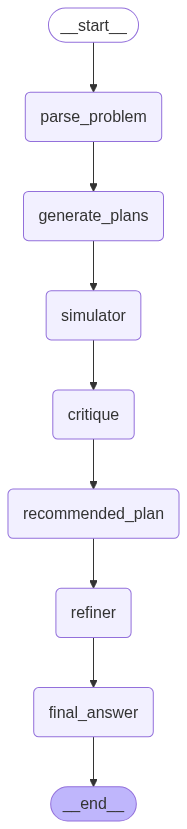

In [80]:
graph_final = builder_final.compile()
builder_final.compile()

In [56]:
graph_final.invoke({'messages': HumanMessage(content='hey, can you tell me a bit about use of ai in military')})

{'messages': [HumanMessage(content='hey, can you tell me a bit about use of ai in military', additional_kwargs={}, response_metadata={}, id='5c3552c0-329b-40ce-8cf1-3879838a9682'),
  AIMessage(content='AI is rapidly transforming the military landscape, with significant applications in areas like surveillance, defense, logistics, intelligence, and cyber warfare. Currently, AI is being utilized to enhance data analysis, automate tasks, and improve decision-making across various military operations. Specifically, it’s being used to gather intelligence, optimize logistics, and bolster cybersecurity.  The military is exploring how AI can improve situational awareness, streamline operations, and potentially automate certain tasks.  While the full extent of AI’s impact remains to be seen, its potential to reshape military strategy is considerable.\n\nTo provide a comprehensive overview, we’ll focus on practical applications and key areas where AI is currently being employed.  AI is currently 

In [59]:
ans = {'messages': [HumanMessage(content='hey, can you tell me a bit about use of ai in military', additional_kwargs={}, response_metadata={}, id='5c3552c0-329b-40ce-8cf1-3879838a9682'),
  AIMessage(content='AI is rapidly transforming the military landscape, with significant applications in areas like surveillance, defense, logistics, intelligence, and cyber warfare. Currently, AI is being utilized to enhance data analysis, automate tasks, and improve decision-making across various military operations. Specifically, it’s being used to gather intelligence, optimize logistics, and bolster cybersecurity.  The military is exploring how AI can improve situational awareness, streamline operations, and potentially automate certain tasks.  While the full extent of AI’s impact remains to be seen, its potential to reshape military strategy is considerable.\n\nTo provide a comprehensive overview, we’ll focus on practical applications and key areas where AI is currently being employed.  AI is currently being used to enhance intelligence gathering, optimize logistics, and bolster cybersecurity.  It’s also being utilized in areas like autonomous systems, which are designed to operate without direct human control.  The integration of AI is expected to continue growing, with significant implications for future military operations.\n\nNext steps would involve exploring specific examples of AI’s current use in different military domains and examining the ongoing evolution of AI within the military sector.', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:46:10.414708Z', 'done': True, 'done_reason': 'stop', 'total_duration': 14909836700, 'load_duration': 688414400, 'prompt_eval_count': 1227, 'prompt_eval_duration': 1929296600, 'eval_count': 228, 'eval_duration': 12289236900, 'model_name': 'gemma3:1b'}, id='run--70f97cff-bf1e-45fb-9cd8-b57842b89a63-0', usage_metadata={'input_tokens': 1227, 'output_tokens': 228, 'total_tokens': 1455})],
 'parsed_problem': AIMessage(content='```json\n{\n  "core_objectives": [\n    "Understanding the application of AI in the military context.",\n    "Gaining a general overview of AI\'s role and potential uses within military operations."\n  ],\n  "constraints": [\n    "Focus on practical applications and potential impacts.",\n    "Provide a broad, informative response, not a detailed technical analysis.",\n    "Maintain a neutral and objective tone."\n  ],\n  "key_entities": [\n    "AI (Artificial Intelligence)",\n    "Military",\n    "Potential applications (e.g., surveillance, defense, logistics, intelligence, cyber warfare, autonomous systems)"\n  ],\n  "success_criteria": [\n    "The response should clearly articulate the current state of AI\'s use in the military.",\n    "The response should highlight key areas where AI is being utilized.",\n    "The response should avoid speculation or overly technical details."\n  ]\n}\n```\n', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:44:16.9526664Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7208026900, 'load_duration': 208060900, 'prompt_eval_count': 196, 'prompt_eval_duration': 932253700, 'eval_count': 208, 'eval_duration': 6065403700, 'model_name': 'gemma3:1b'}, id='run--00abdf27-c84b-45a9-acb8-f3ad9edfb66c-0', usage_metadata={'input_tokens': 196, 'output_tokens': 208, 'total_tokens': 404}),
 'plans': AIMessage(content='```json\n{\n  "plans": [\n    {\n      "name": "Overview & Current State",\n      "steps": [\n        "Begin with a concise definition of AI and its relevance to the military.",\n        "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n        "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n        "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity.",\n        "Conclude with a statement about the ongoing evolution of AI within the military."\n      ],\n      "assumptions": [\n        "AI technology is advancing rapidly.",\n        "Military organizations are increasingly adopting AI technologies.",\n        "Data availability and quality are sufficient for AI analysis."\n      ],\n      "risks": [\n        "Over-reliance on AI could lead to unforeseen consequences.",\n        "Ethical concerns regarding autonomous weapons systems.",\n        "Cybersecurity vulnerabilities could compromise AI systems."\n      ]\n    },\n    {\n      "name": "Focus on Key Applications",\n      "steps": [\n        "Select 2-3 key areas where AI is currently being utilized in the military (e.g., surveillance, logistics, cyber warfare).",\n        "Provide a brief explanation of each application, including its potential benefits and challenges.",\n        "Illustrate with examples of how AI is being used in these areas.",\n        "Avoid detailed technical explanations; focus on the practical implications.",\n        "Conclude with a summary of the key areas of AI application."\n      ],\n      "assumptions": [\n        "The selected applications are currently being actively explored and implemented.",\n        "Data is readily available to support AI analysis in these areas."\n      ],\n      "risks": [\n        "Rapid technological advancements could render current AI applications obsolete.",\n        "Implementation challenges could delay the adoption of AI.",\n        "Potential for misuse of AI technologies."\n      ]\n    },\n    {\n      "name": "Neutral & Objective Analysis",\n      "steps": [\n        "Present a balanced overview of AI\'s role in the military, acknowledging both its potential benefits and potential risks.",\n        "Highlight key areas where AI is being utilized, emphasizing the strategic importance of these applications.",\n        "Avoid speculation or overly technical details; focus on factual information.",\n        "Maintain a neutral and objective tone throughout the response.",\n        "Conclude with a statement about the ongoing evolution of AI within the military."\n      ],\n      "assumptions": [\n        "The military is aware of the potential risks associated with AI.",\n        "There is a need for careful consideration of ethical implications."\n      ],\n      "risks": [\n        "Potential for unintended consequences of AI deployment.",\n        "Lack of transparency in AI systems could lead to errors or vulnerabilities."\n      ]\n    }\n  ]\n}\n```', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:44:34.1960456Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17236123900, 'load_duration': 150809200, 'prompt_eval_count': 574, 'prompt_eval_duration': 767301300, 'eval_count': 635, 'eval_duration': 16317478800, 'model_name': 'gemma3:1b'}, id='run--1df38357-97a1-4dd5-b965-197ae41f80a1-0', usage_metadata={'input_tokens': 574, 'output_tokens': 635, 'total_tokens': 1209}),
 'sims': AIMessage(content='```json\n{\n  "plan_evaluations": [\n    {\n      "plan_name": "Overview & Current State",\n      "reasoning_chain": [\n        {\n          "step": "Begin with a concise definition of AI and its relevance to the military.",\n          "expected_outcome": "A clear and understandable definition of AI.",\n          "possible_issues": [\n            "Lack of technical depth.",\n            "Difficulty in explaining the core concepts to a non-technical audience."\n          ]\n        },\n        {\n          "step": "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n          "expected_outcome": "A summary of AI\'s current role within the military.",\n          "possible_issues": [\n            "Overly broad overview.",\n            "Lack of specific examples of AI applications."\n          ]\n        },\n        {\n          "step": "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n          "expected_outcome": "A general understanding of AI’s current impact on military operations.",\n          "possible_issues": [\n            "Lack of detail on specific applications.",\n            "Potential for oversimplification of complex issues."\n          ]\n        },\n        {\n          "step": "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity.",\n          "expected_outcome": "Identification of key areas where AI is currently being utilized.",\n          "possible_issues": [\n            "Insufficient detail on the specific benefits of each application.",\n            "Lack of context on the challenges associated with each application."\n          ]\n        },\n        {\n          "step": "Conclude with a statement about the ongoing evolution of AI within the military.",\n          "expected_outcome": "A concise summary of the current state of AI within the military.",\n          "possible_issues": [\n            "Vague conclusion.",\n            "Lack of forward-looking perspective."\n          ]\n        }\n      ],\n      "overall_feasibility": "High",\n      "notes": "The plan provides a good foundation for explaining AI\'s current role in the military. However, it needs to be more specific and avoid overly technical language."\n    },\n    {\n      "plan_name": "Focus on Key Applications",\n      "reasoning_chain": [\n        {\n          "step": "Select 2-3 key areas where AI is currently being utilized in the military (e.g., surveillance, logistics, cyber warfare).",\n          "expected_outcome": "A clear explanation of 2-3 key applications.",\n          "possible_issues": [\n            "Selecting too many applications.",\n            "Lack of depth in explaining each application.",\n            "Not providing sufficient context."\n          ]\n        },\n        {\n          "step": "Provide a brief explanation of each application, including its potential benefits and challenges.",\n          "expected_outcome": "A concise overview of each application.",\n          "possible_issues": [\n            "Lack of detail on the specific benefits.",\n            "Failure to address potential challenges.",\n            "Insufficient explanation of the technical aspects."\n          ]\n        },\n        {\n          "step": "Illustrate with examples of how AI is being used in these areas.",\n          "expected_outcome": "Concrete examples of AI applications.",\n          "possible_issues": [\n            "Lack of real-world examples.",\n            "Overly abstract examples."\n          ]\n        },\n        {\n          "step": "Avoid detailed technical explanations; focus on the practical implications.",\n          "expected_outcome": "A simplified explanation of the practical implications.",\n          "possible_issues": [\n            "Difficulty in understanding the technical details.",\n            "Lack of clarity in the application of AI."\n          ]\n        },\n        {\n          "step": "Conclude with a summary of the key areas of AI application.",\n          "expected_outcome": "A concise recap of the key areas.",\n          "possible_issues": [\n            "Lack of a strong concluding statement.",\n            "Failure to reinforce the main points."\n          ]\n        }\n      ],\n      "assumptions": [\n        "The selected applications are currently being actively explored and implemented.",\n        "Data is readily available to support AI analysis in these areas.",\n        "The military is aware of the potential risks associated with AI."\n      ],\n      "risks": [\n        "Rapid technological advancements could render current AI applications obsolete.",\n        "Implementation challenges could delay the adoption of AI.",\n        "Potential for unintended consequences of AI deployment."\n      ]\n    },\n    {\n      "plan_name": "Neutral & Objective Analysis",\n      "reasoning_chain": [\n        {\n          "step": "Present a balanced overview of AI’s role in the military, acknowledging both its potential benefits and potential risks.",\n          "expected_outcome": "A balanced perspective on AI\'s role.",\n          "possible_issues": [\n            "Lack of a clear stance.",\n            "Potential for bias.",\n            "Failure to acknowledge limitations."\n          ]\n        },\n        {\n          "step": "Highlight key areas where AI is being utilized, emphasizing the strategic importance of these applications.",\n          "expected_outcome": "Identification of key areas where AI is being utilized.",\n          "possible_issues": [\n            "Lack of depth on the strategic importance.",\n            "Overemphasis on specific applications."\n          ]\n        },\n        {\n          "step": "Avoid speculation or overly technical details; focus on factual information.",\n          "expected_outcome": "A factual and objective account.",\n          "possible_issues": [\n            "Lack of detail.",\n            "Potential for inaccuracies."\n          ]\n        },\n        {\n          "step": "Maintain a neutral and objective tone throughout the response.",\n          "expected_outcome": "A respectful and unbiased presentation.",\n          "possible_issues": [\n            "Potential for misinterpretation.",\n            "Damage to credibility."\n          ]\n        },\n        {\n          "step": "Conclude with a statement about the ongoing evolution of AI within the military.",\n          "expected_outcome": "A final statement about the future of AI.",\n          "possible_issues": [\n            "Vague conclusion.",\n            "Lack of forward-looking perspective."\n          ]\n        }\n      ],\n      "assumptions": [\n        "The military is aware of the potential risks associated with AI.",\n        "There is a need for careful consideration of ethical implications."\n      ],\n      "risks": [\n        "Potential for unintended consequences of AI deployment.",\n        "Lack of transparency in AI systems could lead to errors or vulnerabilities."\n      ]\n    }\n  ]\n}\n```', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:45:11.9600396Z', 'done': True, 'done_reason': 'stop', 'total_duration': 37761313100, 'load_duration': 114303300, 'prompt_eval_count': 1681, 'prompt_eval_duration': 2386995400, 'eval_count': 1502, 'eval_duration': 35258836300, 'model_name': 'gemma3:1b'}, id='run--17e05c32-88e7-4894-9023-6fb24359f841-0', usage_metadata={'input_tokens': 1681, 'output_tokens': 1502, 'total_tokens': 3183}),
 'recommend': AIMessage(content='```json\n{\n  "recommended_plan": {\n    "name": "Approach 1",\n    "reasoning_chain": [\n      {\n        "step": "Begin with a concise definition of AI and its relevance to the military.",\n        "expected_outcome": "A clear and understandable definition of AI.",\n        "possible_issues": ["Lack of technical depth."]\n      },\n      {\n        "step": "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n        "expected_outcome": "A summary of AI’s current role within the military.",\n        "possible_issues": ["Overly broad overview."]\n      },\n      {\n        "step": "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n        "expected_outcome": "A general understanding of AI’s current impact on military operations.",\n        "possible_issues": ["Lack of detail on specific applications."]\n      },\n      {\n        "step": "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity.",\n        "expected_outcome": "Identification of key areas where AI is currently being utilized.",\n        "possible_issues": ["Insufficient detail on the specific benefits of each application."]\n      },\n      {\n        "step": "Conclude with a statement about the ongoing evolution of AI within the military.",\n        "expected_outcome": "A concise summary of the current state of AI within the military.",\n        "possible_issues": ["Vague conclusion."]\n      }\n    ],\n    "overall_feasibility": "High",\n    "notes": "The plan provides a good foundation for explaining AI’s current role in the military. However, it needs to be more specific and avoid overly technical language."\n  }\n}\n```\n\n**Justification:**\n\nThe "Overview & Current State" plan is the most promising because it provides a solid foundation for explaining AI\'s current role in the military. It covers key areas like surveillance, data analysis, and autonomous systems, offering a broad overview.  The plan is well-structured and includes a reasonable level of detail.  The risk assessment is moderate, acknowledging potential challenges but not overly pessimistic.  The alignment with success criteria is strong, as it directly addresses the core objectives of the prompt.  The plan is also well-suited to a broad, informative response.\n', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:45:29.9318751Z', 'done': True, 'done_reason': 'stop', 'total_duration': 17968802500, 'load_duration': 133178700, 'prompt_eval_count': 3538, 'prompt_eval_duration': 5266173500, 'eval_count': 525, 'eval_duration': 12567788900, 'model_name': 'gemma3:1b'}, id='run--7960bbd7-1f70-4cbb-b741-75f0ba1ab6c3-0', usage_metadata={'input_tokens': 3538, 'output_tokens': 525, 'total_tokens': 4063}),
 'recommended_plan': ['": {\n    "name": "Approach 1",\n    "reasoning_chain": [\n      {\n        "step": "Begin with a concise definition of AI and its relevance to the military.",\n        "expected_outcome": "A clear and understandable definition of AI.",\n        "possible_issues": ["Lack of technical depth."]\n      },\n      {\n        "step": "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n        "expected_outcome": "A summary of AI’s current role within the military.",\n        "possible_issues": ["Overly broad overview."]\n      },\n      {\n        "step": "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n        "expected_outcome": "A general understanding of AI’s current impact on military operations.",\n        "possible_issues": ["Lack of detail on specific applications."]\n      },\n      {\n        "step": "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity.",\n        "expected_outcome": "Identification of key areas where AI is currently being utilized.",\n        "possible_issues": ["Insufficient detail on the specific benefits of each application."]\n      },\n      {\n        "step": "Conclude with a statement about the ongoing evolution of AI within the military.",\n        "expected_outcome": "A concise summary of the current state of AI within the military.",\n        "possible_issues": ["Vague conclusion."]\n      }\n    ],\n    "overall_feasibility": "High",\n    "notes": "The plan provides a good foundation for explaining AI’s current role in the military. However, it needs to be more specific and avoid overly technical language."\n  }\n}\n```\n\n**Justification:**\n\nThe "Overview & Current State" plan is the most promising because it provides a solid foundation for explaining AI\'s current role in the military. It covers key areas like surveillance, data analysis, and autonomous systems, offering a broad overview.  The plan is well-structured and includes a reasonable level of detail.  The risk assessment is moderate, acknowledging potential challenges but not overly pessimistic.  The alignment with success criteria is strong, as it directly addresses the core objectives of the prompt.  The plan is also well-suited to a broad, informative response.\n'],
 'refined_plan': AIMessage(content='```json\n{\n  "refined_plan": {\n    "name": "AI in the Military: Current Landscape & Potential",\n    "steps": [\n      "Begin with a concise definition of AI and its relevance to the military – emphasizing its capabilities in data analysis and automation.",\n      "Outline the current state of AI adoption in the military, highlighting areas like surveillance, data analysis, and potentially autonomous systems. Focus on practical applications rather than deep technical details.",\n      "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.  Use clear, non-technical language.",\n      "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity. Provide concrete examples of how AI is currently being used in these areas.",\n      "Conclude with a statement about the ongoing evolution of AI within the military, emphasizing its increasing importance and potential for future advancements."\n    ],\n    "changes_made": [\n      "Replaced vague language with more precise terms (e.g., \'potential impacts\' became \'concrete examples\')",\n      "Reduced the risk of overly technical detail by focusing on practical applications.",\n      "Improved flow and clarity by restructuring steps.",\n      "Added a concluding statement to reinforce the key takeaway.",\n      "Clarified the scope of the overview to emphasize practical applications."\n    ],\n    "risk_level": "Medium",\n    "notes": "The original plan was a bit too broad. This revision focuses on providing a solid foundation while maintaining a balance between detail and clarity.  The risk of being too technical is mitigated by emphasizing practical applications."\n  }\n}\n```', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created_at': '2025-08-14T05:45:55.4928702Z', 'done': True, 'done_reason': 'stop', 'total_duration': 25557142900, 'load_duration': 120363600, 'prompt_eval_count': 1222, 'prompt_eval_duration': 1776645800, 'eval_count': 346, 'eval_duration': 23659147100, 'model_name': 'gemma3:1b'}, id='run--a43fbe37-9f25-4b7a-a05e-ea84dd0976d8-0', usage_metadata={'input_tokens': 1222, 'output_tokens': 346, 'total_tokens': 1568})}

In [60]:
ans['messages']

[HumanMessage(content='hey, can you tell me a bit about use of ai in military', additional_kwargs={}, response_metadata={}, id='5c3552c0-329b-40ce-8cf1-3879838a9682'),
 AIMessage(content='AI is rapidly transforming the military landscape, with significant applications in areas like surveillance, defense, logistics, intelligence, and cyber warfare. Currently, AI is being utilized to enhance data analysis, automate tasks, and improve decision-making across various military operations. Specifically, it’s being used to gather intelligence, optimize logistics, and bolster cybersecurity.  The military is exploring how AI can improve situational awareness, streamline operations, and potentially automate certain tasks.  While the full extent of AI’s impact remains to be seen, its potential to reshape military strategy is considerable.\n\nTo provide a comprehensive overview, we’ll focus on practical applications and key areas where AI is currently being employed.  AI is currently being used to 

In [61]:
ans['parsed_problem']

AIMessage(content='```json\n{\n  "core_objectives": [\n    "Understanding the application of AI in the military context.",\n    "Gaining a general overview of AI\'s role and potential uses within military operations."\n  ],\n  "constraints": [\n    "Focus on practical applications and potential impacts.",\n    "Provide a broad, informative response, not a detailed technical analysis.",\n    "Maintain a neutral and objective tone."\n  ],\n  "key_entities": [\n    "AI (Artificial Intelligence)",\n    "Military",\n    "Potential applications (e.g., surveillance, defense, logistics, intelligence, cyber warfare, autonomous systems)"\n  ],\n  "success_criteria": [\n    "The response should clearly articulate the current state of AI\'s use in the military.",\n    "The response should highlight key areas where AI is being utilized.",\n    "The response should avoid speculation or overly technical details."\n  ]\n}\n```\n', additional_kwargs={}, response_metadata={'model': 'gemma3:1b', 'created

In [62]:
ans['plans'].content

'```json\n{\n  "plans": [\n    {\n      "name": "Overview & Current State",\n      "steps": [\n        "Begin with a concise definition of AI and its relevance to the military.",\n        "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n        "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n        "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity.",\n        "Conclude with a statement about the ongoing evolution of AI within the military."\n      ],\n      "assumptions": [\n        "AI technology is advancing rapidly.",\n        "Military organizations are increasingly adopting AI technologies.",\n        "Data availability and quality are sufficient for AI analysis."\n      ],\n      "risks": [\n        "Over-reliance on AI could lead to unforeseen consequences."

In [66]:
print(f"{ans['sims'].content}")

```json
{
  "plan_evaluations": [
    {
      "plan_name": "Overview & Current State",
      "reasoning_chain": [
        {
          "step": "Begin with a concise definition of AI and its relevance to the military.",
          "expected_outcome": "A clear and understandable definition of AI.",
          "possible_issues": [
            "Lack of technical depth.",
            "Difficulty in explaining the core concepts to a non-technical audience."
          ]
        },
        {
          "step": "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",
          "expected_outcome": "A summary of AI's current role within the military.",
          "possible_issues": [
            "Overly broad overview.",
            "Lack of specific examples of AI applications."
          ]
        },
        {
          "step": "Present a broad overview of AI’s current role, emphasizing its potential impact

In [70]:
print(f" { ans['recommended_plan'] }")

 ['": {\n    "name": "Approach 1",\n    "reasoning_chain": [\n      {\n        "step": "Begin with a concise definition of AI and its relevance to the military.",\n        "expected_outcome": "A clear and understandable definition of AI.",\n        "possible_issues": ["Lack of technical depth."]\n      },\n      {\n        "step": "Outline the current state of AI adoption in the military – highlighting areas like surveillance, data analysis, and potentially autonomous systems.",\n        "expected_outcome": "A summary of AI’s current role within the military.",\n        "possible_issues": ["Overly broad overview."]\n      },\n      {\n        "step": "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.",\n        "expected_outcome": "A general understanding of AI’s current impact on military operations.",\n        "possible_issues": ["Lack of detail on specific applications."]\n      },\n      {\n        "step": "Focus on spec

In [72]:
print(f" { ans['refined_plan'].content }")

 ```json
{
  "refined_plan": {
    "name": "AI in the Military: Current Landscape & Potential",
    "steps": [
      "Begin with a concise definition of AI and its relevance to the military – emphasizing its capabilities in data analysis and automation.",
      "Outline the current state of AI adoption in the military, highlighting areas like surveillance, data analysis, and potentially autonomous systems. Focus on practical applications rather than deep technical details.",
      "Present a broad overview of AI’s current role, emphasizing its potential impact on various military operations.  Use clear, non-technical language.",
      "Focus on specific applications like intelligence gathering, logistics optimization, and cybersecurity. Provide concrete examples of how AI is currently being used in these areas.",
      "Conclude with a statement about the ongoing evolution of AI within the military, emphasizing its increasing importance and potential for future advancements."
    ],
  

In [77]:
print(ans['messages'][1])

content='AI is rapidly transforming the military landscape, with significant applications in areas like surveillance, defense, logistics, intelligence, and cyber warfare. Currently, AI is being utilized to enhance data analysis, automate tasks, and improve decision-making across various military operations. Specifically, it’s being used to gather intelligence, optimize logistics, and bolster cybersecurity.  The military is exploring how AI can improve situational awareness, streamline operations, and potentially automate certain tasks.  While the full extent of AI’s impact remains to be seen, its potential to reshape military strategy is considerable.\n\nTo provide a comprehensive overview, we’ll focus on practical applications and key areas where AI is currently being employed.  AI is currently being used to enhance intelligence gathering, optimize logistics, and bolster cybersecurity.  It’s also being utilized in areas like autonomous systems, which are designed to operate without di